# Used this notebook for prediction using C3D feature only

In [37]:
!pip install -U -q tensorflow

In [38]:
#Import libraries
import pandas as pd
from keras import Sequential
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from progressbar import ProgressBar

# for reproducability
from numpy.random import seed
seed(1)
import tensorflow as tf



In [39]:
from google.colab import drive
import os
drive.mount('/content/drive/')
#os.chdir('/content/drive/My Drive/CA684_Assignment/')
os.chdir('/content/drive/My Drive/CA684/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
def read_C3D_data(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()]
    return C3D

In [41]:
# Load the ground truth values
truth_label_path = './Dev-set/Ground-truth/'
ground_truth_labels = pd.read_csv(truth_label_path+'ground-truth.csv')

In [42]:
# Load the C3D feature values in a Panda's dataframe
c3d_feature_path = './Dev-set/'
# Load video related features first
# it helps with the organization of the video names
videos = ground_truth_labels.video.values
pbar = ProgressBar()

c3d_features = pd.DataFrame({'video': videos,
                   'C3D': [read_C3D_data(c3d_feature_path +'C3D'+'/'+ os.path.splitext(videos[video])[0]+'.txt') for video in pbar(range(len(videos)))],
                       })


100% (6000 of 6000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


In [43]:
c3d_features.to_csv('c3d_features_dev_data.csv')
c3d_features.shape

(6000, 2)

In [44]:
X = np.stack(c3d_features['C3D'].values)
Y = ground_truth_labels[['short-term_memorability','long-term_memorability']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [45]:
# Load testing data
test_path = './Test-set/'
test_videos = os.listdir(test_path+'C3D_test')

pbar = ProgressBar()
c3d_test = pd.DataFrame({'video': test_videos,
                   'C3D': [read_C3D_data(test_path+'C3D_test'+'/'+ test_videos[video]) for video in pbar(range(len(test_videos)))],
                       })

100% (2000 of 2000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [46]:
X_test = np.stack(c3d_test['C3D'].values)

# Model

In [47]:
# Create a Sequential Model
model = Sequential()
model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               20400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 402       
Total params: 61,002
Trainable params: 61,002
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Compile the model
model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history=model.fit(x=X_train,y=Y_train,batch_size=50,epochs=20,shuffle=True,verbose=False, validation_data=(X_val, Y_val)) 

# Visualisaton of results
- Visualising the loss and training results
- Visualising the short-term and long term scatter plot

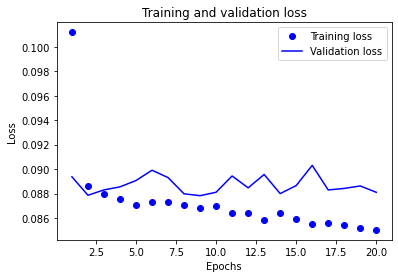

In [49]:
# Visualising the training loss vs validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


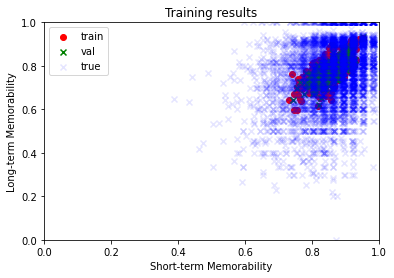

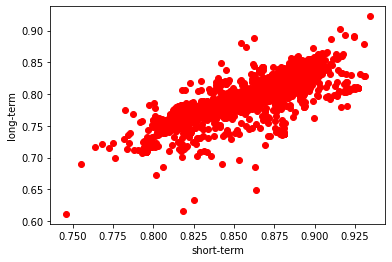

In [50]:
Y_predicted_train = model.predict(X_train)
Y_predicted_validation = model.predict(X_val)

plt.figure()
plt.scatter(Y_predicted_train[:,0],Y_predicted_train[:,1],marker='o',c='r',label='train')
plt.scatter(Y_predicted_validation[:,0],Y_predicted_validation[:,1],marker='x',c='g',label='val')
plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('Short-term Memorability')
plt.ylabel('Long-term Memorability')
plt.title('Training results')
plt.show()

# plot testing results
Y_pred = model.predict(X_test[:,:],batch_size=32)
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.show()


In [51]:
Y_prediction = model.predict(X_val)

In [52]:
# Function to predict the Spearmann's correlation coefficient
def Predict_Spearman_Score(Y_prediction,Y_actual):
    '''Calculate the Spearmann's correlation coefficient'''
    Y_prediction = np.squeeze(Y_prediction)
    Y_actual = np.squeeze(Y_actual)
    if Y_prediction.shape != Y_actual.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_prediction.shape) == 1:
            Res = pd.DataFrame({'Y_actual':Y_actual,'Y_prediction':Y_prediction})
            score_mat = Res[['Y_actual','Y_prediction']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for k in range(Y_prediction.shape[1]):
                if k == 0:
                    print("Short Term Memorability")
                    Predict_Spearman_Score(Y_prediction[:,k],Y_actual[:,k])
                else:
                    print("\nLong Term Memorability")
                    Predict_Spearman_Score(Y_prediction[:,k],Y_actual[:,k])

In [53]:
# Predict Short term and Long term Spearmann's correlation coefficient scores
Predict_Spearman_Score(Y_prediction,Y_val)

Short Term Memorability
The Spearman's correlation coefficient is: 0.295

Long Term Memorability
The Spearman's correlation coefficient is: 0.123


In [54]:
# Predict loss and accuracy of Sequential mode
score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.08810045570135117
Validation accuracy: 0.7099999785423279
